#**Predicting Home Prices with Multi-modal Data**

#*Background: Use Case*

We have a dataset describing homes, including four photos per home and some other structured features, along with an associated home sale price label, to try to fit a predictive model of sale price.

The use case here is as follows. Customers are individual sellers, buyers, and real estate agents, who wish to set their sale price, or their offer price on a new home. You can assume the user will always have these features available to them at the time of prediction (i.e., the four photo types in question, as well as the structured features). 

#**Importing the Data**

I've provided some starter code for importing the data...

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 KB 18.7 MB/s eta 0:00:00
  Created wheel for atomicwrites: filename=atomicwrites-1.4.1-py2.py3-none-any.whl size=6955 sha256=b20181e104b21e16b46e5a72b3ce194cf0291fa847017ad5781a1436874e356d
  Stored in directory: /root/.cache/pip/wheels/2a/b5/06/d2f34584f352e4af7d1d7ac1baf38b5d24142c8044cd024fd5
Successfully built atomicwrites


/usr/local/lib/python3.9/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Mounted at /content/drive
Download /root/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!
The shape of our kitchen image array is (535, 200, 200, 3)


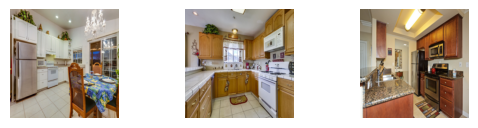

In [1]:
try:
  from uszipcode import SearchEngine
except ImportError as error:
  !pip install uszipcode
  from uszipcode import SearchEngine

import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import glob
from PIL import Image

drive.mount('/content/drive', force_remount=True)

# Replace with your basepath in your Google Drive
basePath = 'drive/MyDrive/Teaching/Courses/BA 865/BA865-2023/Lecture Materials/D/datasets/Houses Dataset'

# These are the column headers for the home characteristics data.
cols = ['bedrooms','bathrooms','area','zipcode','price']

# We first pull in the numeric features for houses from the text file.
numericData = pd.read_csv(f'{basePath}/all/HousesInfo.txt', sep=" ",header=None,names=cols)

# Pulling out the labels
labels = numericData['price']

# Now removing the label and zipcode from the dataset (because some zipcodes are only represented by one house, for example.)
homeFeatures = numericData.drop(columns=['price','zipcode'])

# Pulling in population density and the fraction of occupied housing units in the zipcode.
sr = SearchEngine()
population_density = []
frac_occupied_housing = []
median_home_price = []
median_income = []
for zip in numericData['zipcode']:
  z = sr.by_zipcode(zip)
  population_density.append(z.population_density)
  houses = z.housing_units
  occ = z.occupied_housing_units
  frac_occupied_housing.append(occ/houses)
  median_home_price = z.median_home_value
  median_income = z.median_household_income

homeFeatures = homeFeatures.assign(pop_dens=population_density,frac_occ=frac_occupied_housing,med_price=median_home_price,income=median_income)

image_size = (200,200)

# Reading the images into memory may take a minute - be patient :).
def read_images(imageType):
  image_list = []
  for file in glob.glob(f"{basePath}/all/{imageType}/*"):
    im=Image.open(file)
    im=im.resize(size=image_size)
    image_list.append(np.divide(np.array(im),255))
  return np.stack(image_list)

front_image = read_images("frontal")
bathroom_image = read_images("bathroom")
bedroom_image = read_images("bedroom")
kitchen_image = read_images("kitchen")

print(f'The shape of our kitchen image array is {kitchen_image.shape}')

# Our 535 houses' images are all now in memory as 100x100 pictures, with 3 channels (RGB).
for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(kitchen_image[i])
    plt.axis("off")

Shuffle the different arrays, in unison (preserving row ordering across the arrays).

In [2]:
shuffled_indices= np.arange(front_image.shape[0])
np.random.shuffle(shuffled_indices)

front_image = front_image[shuffled_indices]
kitchen_image = kitchen_image[shuffled_indices]
bathroom_image = bathroom_image[shuffled_indices]
bedroom_iamge = bedroom_image[shuffled_indices]
homeFeatures = homeFeatures.iloc[shuffled_indices]
labels = labels[shuffled_indices]

#**Create a Multi-Modal NN from Scratch (13 points)**

#*Define Your Model*

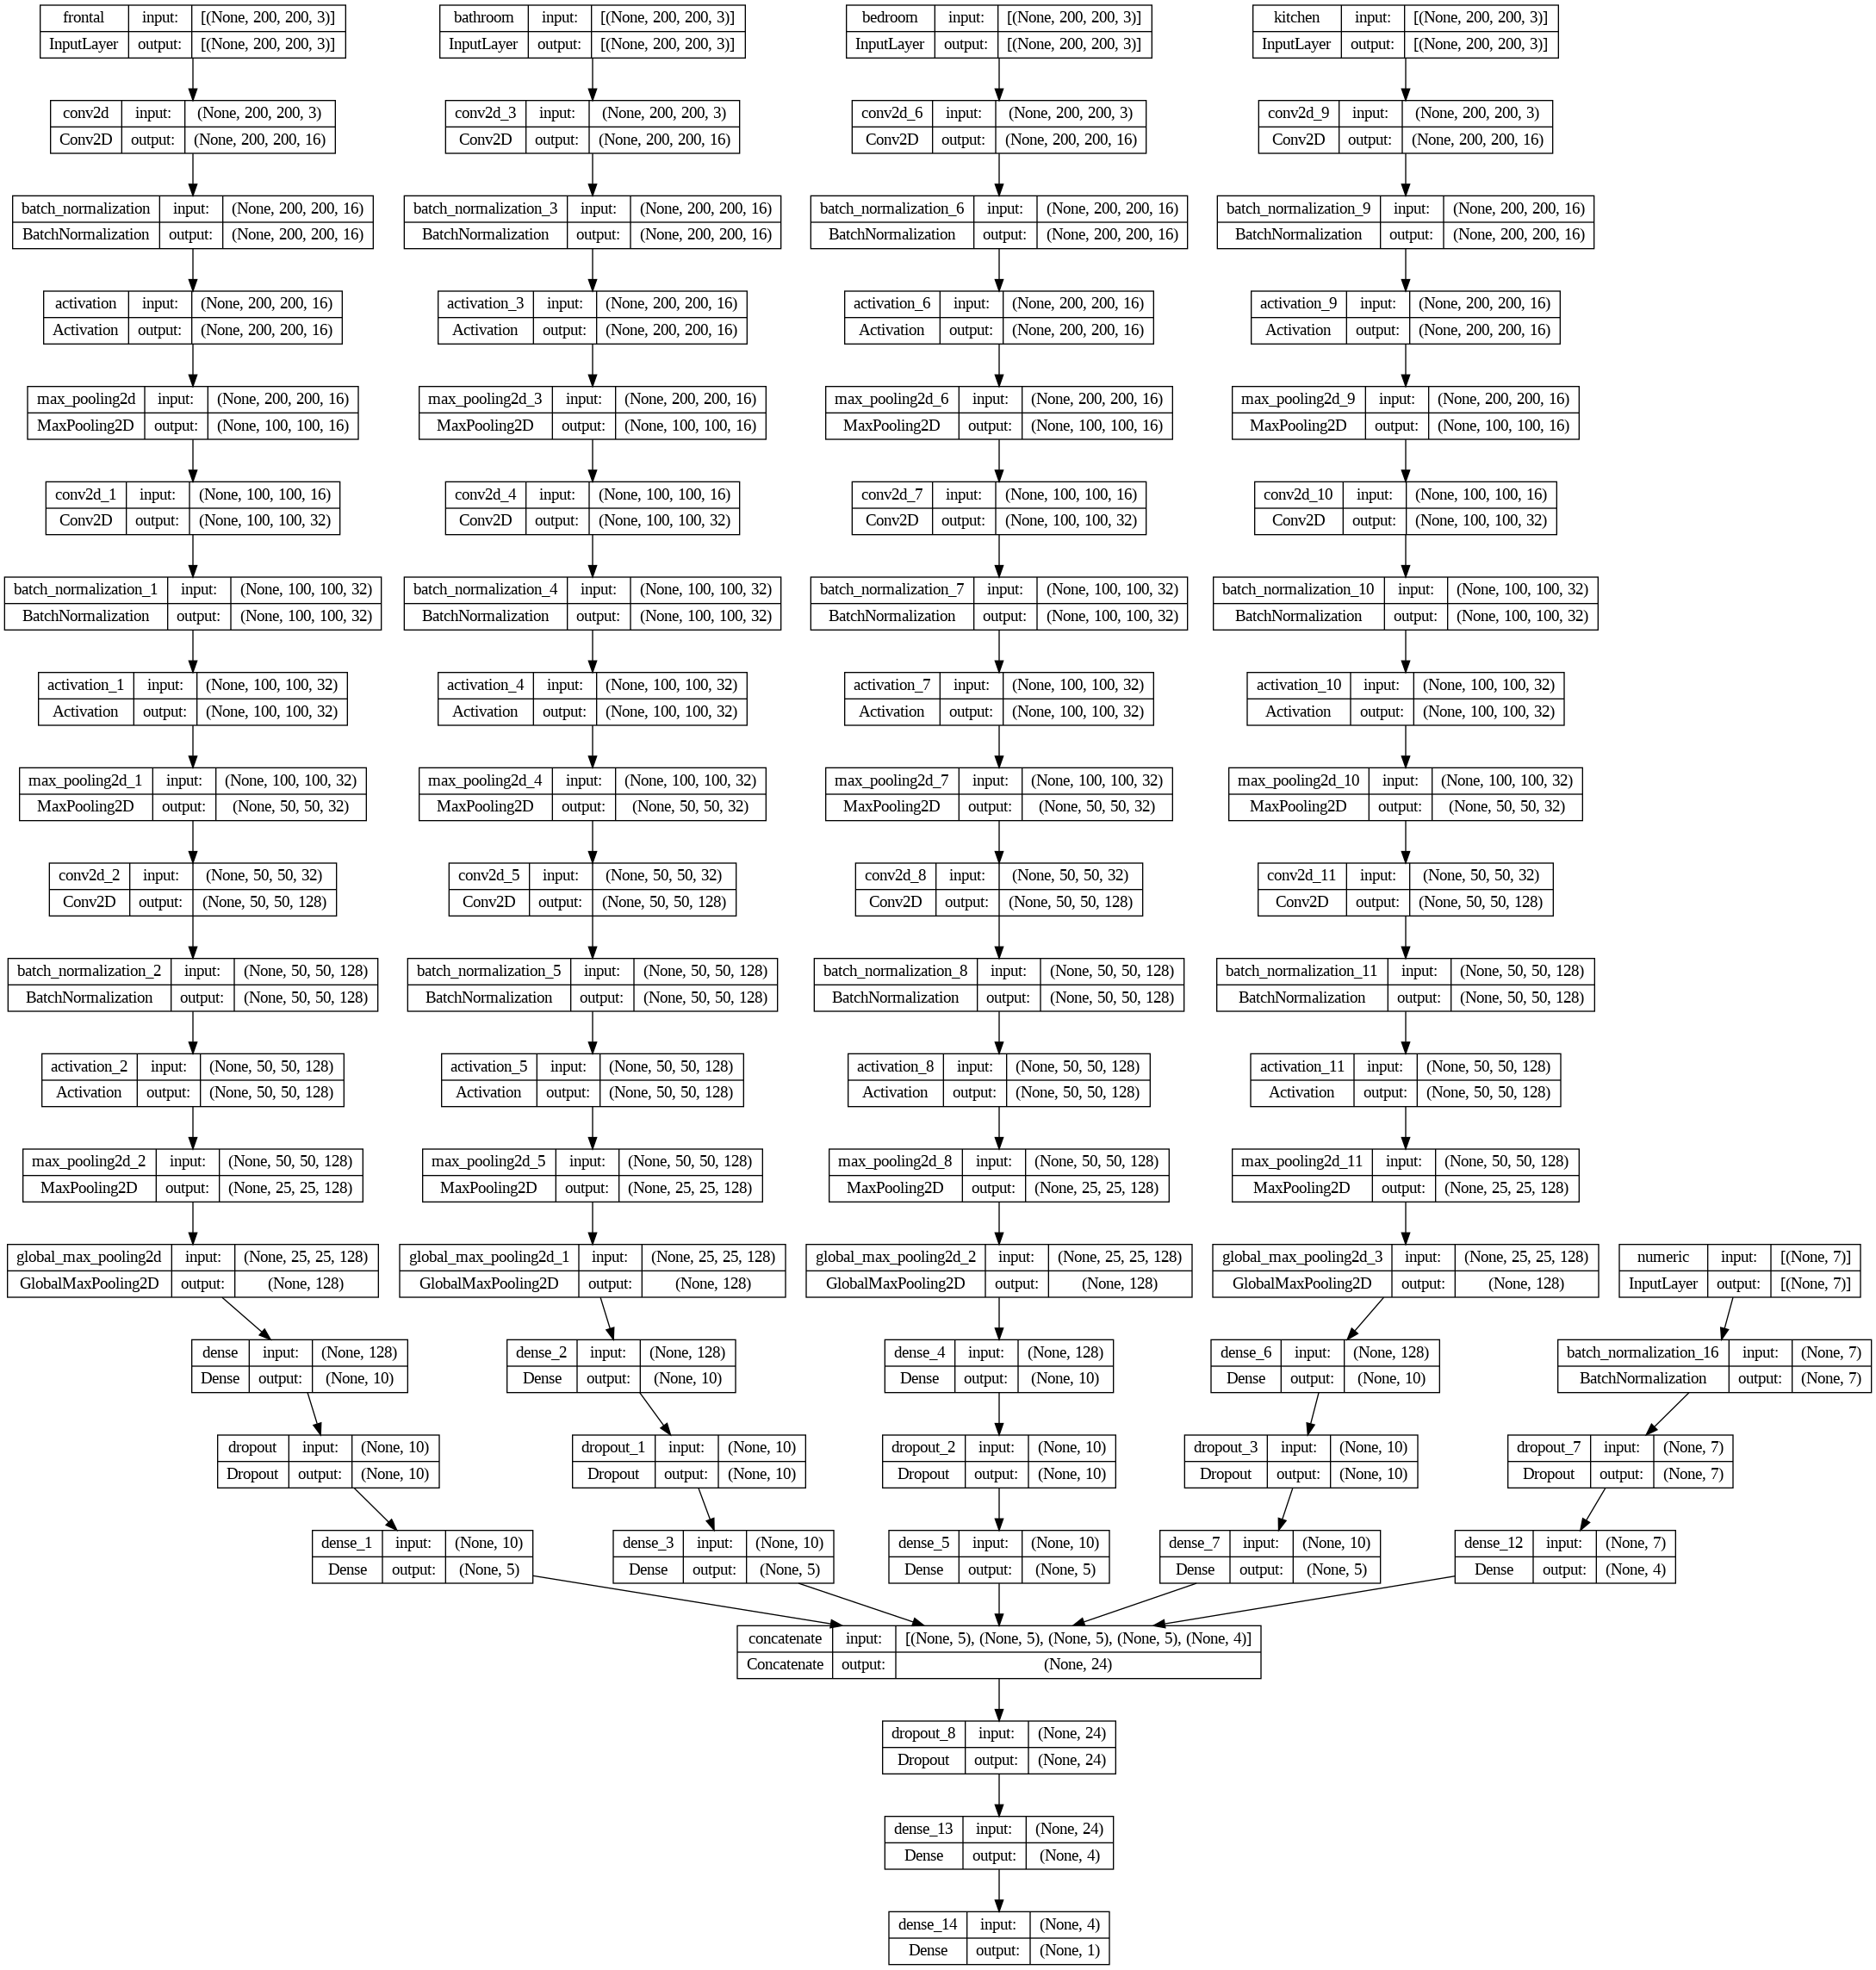

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

def create_mlp(name):

    inputs = layers.Input((len(homeFeatures.columns)),name="numeric")
    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(50, activation="relu",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(25, activation="relu",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(10, activation="relu",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(10, activation="relu",kernel_regularizer="l2")(x)
    x = layers.BatchNormalization()(inputs)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(4, activation="relu")(x)
    
    model = keras.Model(inputs, outputs)
    
    return model

def create_cnn(name="generic"):

    inputs = layers.Input((image_size[0],image_size[1],3),name=name)
    x = layers.Conv2D(16, (3,3),padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x) 
    x = layers.Conv2D(32,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dense(10, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(5, activation="relu")(x)
    
    model = keras.Model(inputs, outputs)
    return model

def build_model():
    frontal_model = create_cnn("frontal")
    bathroom_model = create_cnn("bathroom")
    bedroom_model = create_cnn("bedroom")
    kitchen_model = create_cnn("kitchen")
    numeric_model = create_mlp("numeric")

    branch_merge = layers.concatenate([frontal_model.output, bathroom_model.output, bedroom_model.output, kitchen_model.output, numeric_model.output])

    x = layers.Dropout(0.2)(branch_merge)
    x = layers.Dense(4, activation="relu")(x)
    final_output = layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs=[frontal_model.input, bathroom_model.input, bedroom_model.input, kitchen_model.input,numeric_model.input], outputs=final_output)

    model.compile(loss="mae", optimizer="adam")

    return model

model = build_model()
keras.utils.plot_model(model, show_shapes=True)

#*Fit Your Model*

Train your model and track validation loss in terms of MAPE. You should define a callback that retains the best performing model across epochs, in terms of validation loss.

Note 1: You needed to apply cross validation here, based on MAE. The sample is much too small to use a simple train-validation split.

In [4]:
train_data = [front_image,bathroom_image,bedroom_image,kitchen_image,homeFeatures]

k = 3
num_val_samples = len(train_data[0]) // k # floor division (i.e., round down to nearest integer.)
num_epochs = 20
batch_size = 5

all_train_mae_histories = []  
all_val_mae_histories = []
for i in range(k): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)
    # if I slice past the end of the array, it just gives me what it can find! No errors.
    # This is important here, because the last fold won't produce an error, despite our slice going well beyond the end of the array.
    print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples-1) # minus 1 because a slice is up to and not including the second index.
    #val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_data = [item[i*num_val_samples: (i+1) * num_val_samples] for item in train_data]
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
    print("Training data includes observations 0 through",i*num_val_samples-1,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")
    
    partial_train_data = []
    for item in train_data:
      partial_train_data.append(np.concatenate([item[:i * num_val_samples],item[(i + 1) * num_val_samples:]],axis=0))
       
    partial_train_targets = np.concatenate([labels[:i * num_val_samples], labels[(i + 1) * num_val_samples:]], axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=1)
    mae_val_history = history.history['val_loss']
    mae_train_history = history.history['loss']
    all_val_mae_histories.append(mae_val_history)
    all_train_mae_histories.append(mae_train_history)

average_mae_train_history = [np.mean([x[i] for x in all_train_mae_histories]) for i in range(num_epochs)]
average_mae_val_history = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]

Processing fold #: 0
Validation data includes observations 0 through 177
Training data includes observations 0 through -1 joined with observations 178 through the final observation.

Epoch 1/20
72/72 [==============================] - 24s 38ms/step - loss: 580820.5000 - val_loss: 643258.9375
Epoch 2/20
72/72 [==============================] - 1s 19ms/step - loss: 577497.2500 - val_loss: 614384.5000
Epoch 3/20
72/72 [==============================] - 1s 19ms/step - loss: 547087.9375 - val_loss: 592221.1875
Epoch 4/20
72/72 [==============================] - 1s 19ms/step - loss: 456158.3438 - val_loss: 530049.8750
Epoch 5/20
72/72 [==============================] - 1s 20ms/step - loss: 370374.5625 - val_loss: 434583.6250
Epoch 6/20
72/72 [==============================] - 1s 20ms/step - loss: 334976.5000 - val_loss: 366101.2188
Epoch 7/20
72/72 [==============================] - 1s 19ms/step - loss: 332885.8750 - val_loss: 342235.8125
Epoch 8/20
72/72 [==============================] - 1

Plot your model's loss over epochs to undertand its performance. It appears that my model tops out around 7-8 epochs but it does not overfit. The MAE ends up around $340,000.

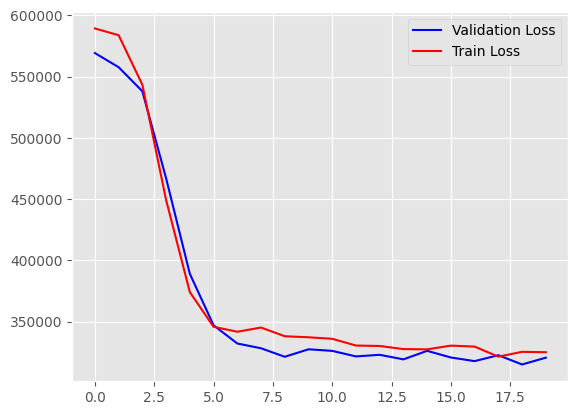

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Make plot...
plt.plot(average_mae_val_history,c="b")
plt.plot(average_mae_train_history,c="r")
plt.legend(['Validation Loss','Train Loss'])
plt.show()

#**Now Using a Pre-Trained Model**

In this section, we will replace the CNN components of the 'from-scratch' network with those from a pre-trained model. We will use VGG16 to pre-process images into numeric vectors, and then feed those vectors into a standard, dense feed-forward NN to generate predictions. I'm using a version of ResNet here.

#*Load Pre-Trained Model's CNN layers*

In [ ]:
conv_base_ResNetV2 = keras.applications.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size[0],image_size[1], 3)
)

#conv_base_ResNetV2.summary()

234545216/234545216 [==============================] - 11s 0us/step


#*Pre-process Your Images Through the Pre-trained Model's CNN Layers*

You need to write a quick function that loops over your images and runs them through the pre-trained CNN layers to get back the numeric vector representations.

In [ ]:
def get_ResNet_representations(dataset):
    all_batch_vector_reps = []
    preprocessed_images = keras.applications.resnet_v2.preprocess_input(dataset)
    batch_vector_rep = conv_base_ResNetV2.predict(preprocessed_images)
    all_batch_vector_reps.append(batch_vector_rep)
    return np.concatenate(all_batch_vector_reps)
  
front_image_ResNet = get_ResNet_representations(front_image)
bedroom_image_ResNet =  get_ResNet_representations(bedroom_image)
bathroom_image_ResNet =  get_ResNet_representations(bathroom_image)
kitchen_image_ResNet =  get_ResNet_representations(kitchen_image)

# These are 2048, 7x7 dimensional feature maps - you can pass them into a GlobalMaxPooling2D layer.
print(front_image_ResNet.shape)

# Recall we already created labels and homeFeatures data earlier, which are still numpy arrays in memory.
print(homeFeatures.shape)
print(labels.shape)

17/17 [==============================] - 3s 194ms/step
(535, 7, 7, 2048)
(535, 7)
(535,)


#*Define Your Dense Network*

You will once again have a multi-branch network, but you've no longer any need for CNNs here. Just use a couple of Dense layers, merge the branches together and then produce a numeric prediction.

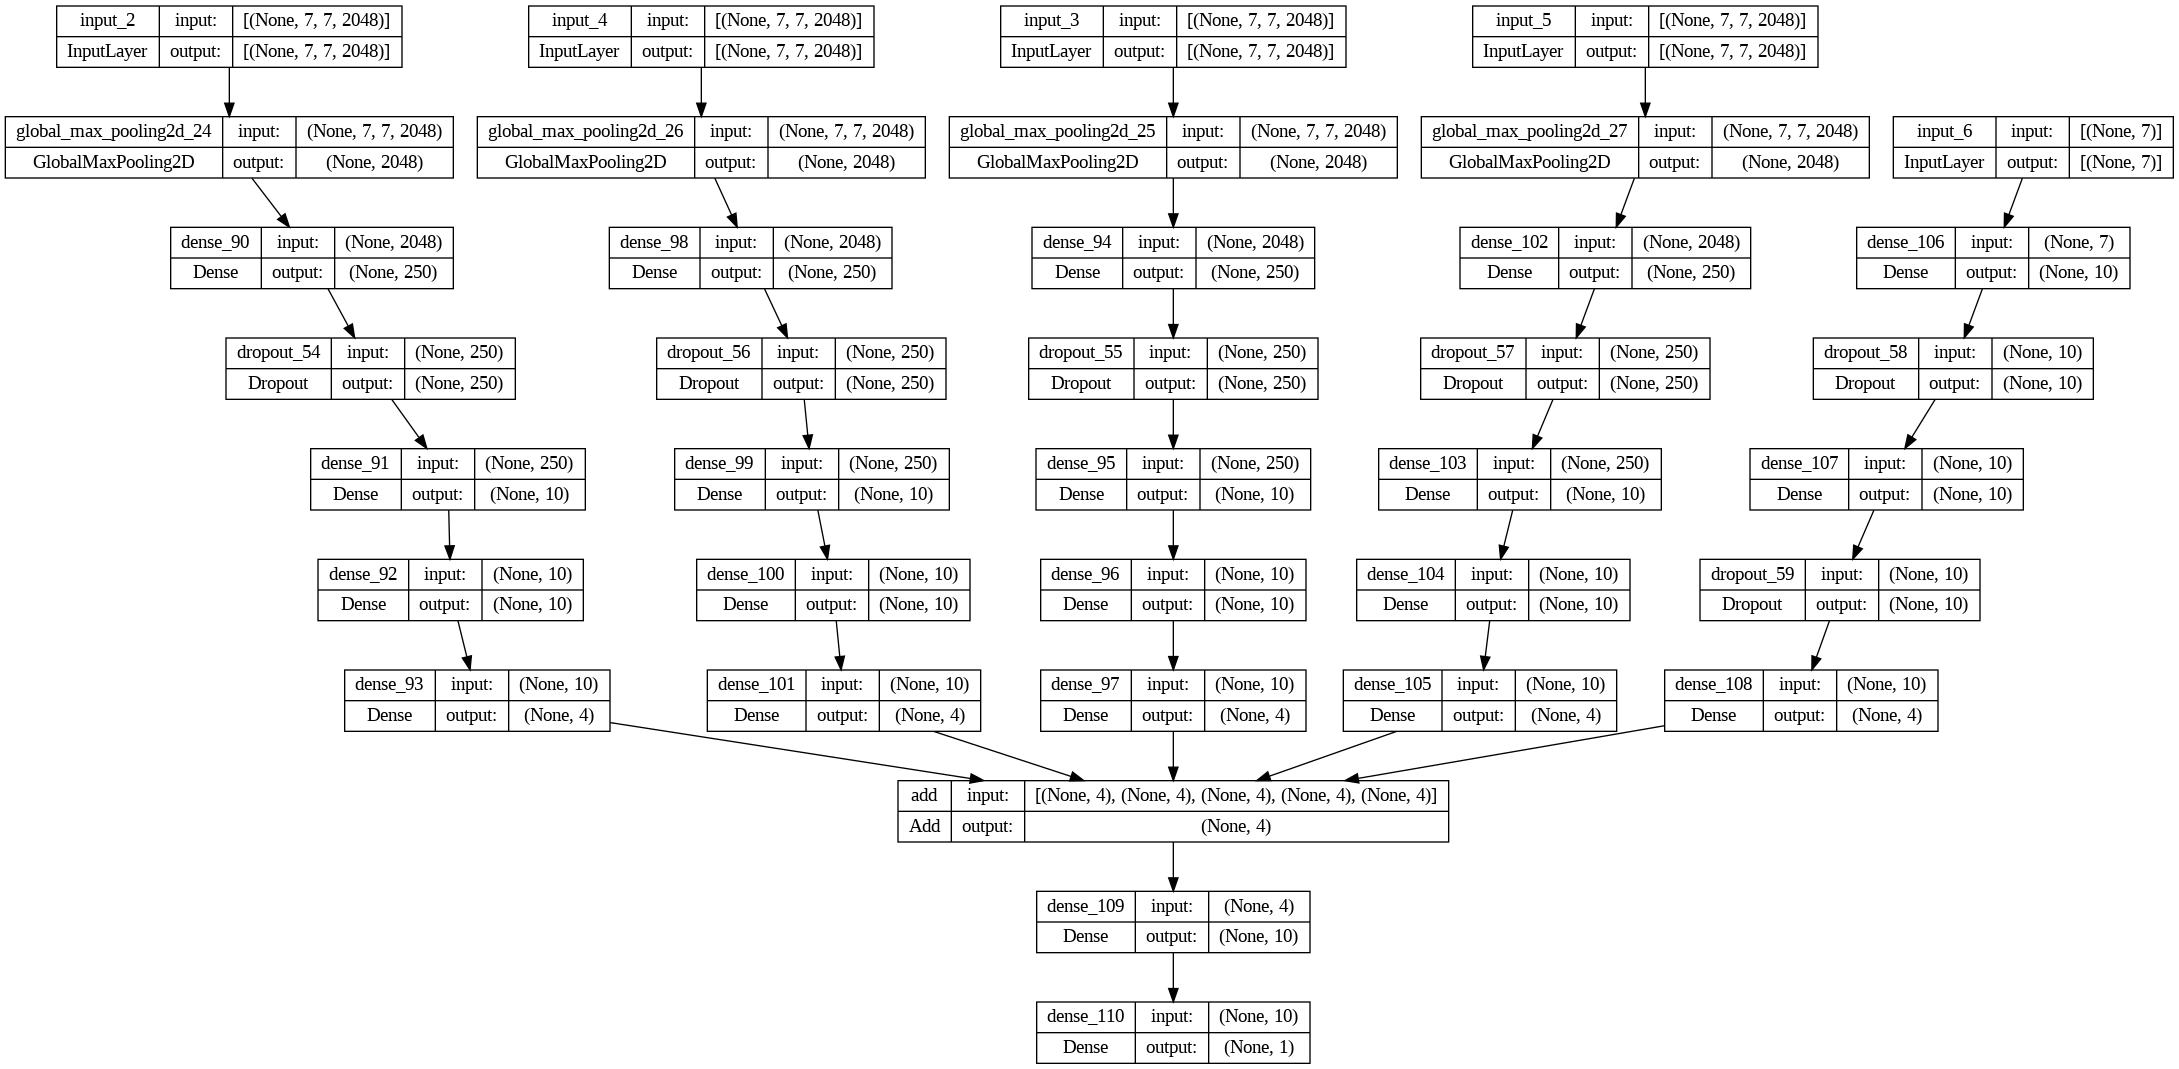

In [ ]:
dropout_rate = 0.3
layer_args = {
    #'kernel_regularizer':'l2',
    'activation':'relu'   
}

def build_model_ResNet():

    front_inputs = layers.Input(front_image_ResNet.shape[1:])
    x = layers.GlobalMaxPooling2D()(front_inputs)
    x = layers.Dense(250, **layer_args)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(10, **layer_args)(x)
    x = layers.Dense(10, **layer_args)(x)
    front_outputs = layers.Dense(4, **layer_args)(x)

    bedroom_inputs = layers.Input(bedroom_image_ResNet.shape[1:])
    x = layers.GlobalMaxPooling2D()(bedroom_inputs)
    x = layers.Dense(250, **layer_args)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(10, **layer_args)(x)
    x = layers.Dense(10, **layer_args)(x)
    bedroom_outputs = layers.Dense(4, **layer_args)(x)

    bathroom_inputs = layers.Input(bathroom_image_ResNet.shape[1:])
    x = layers.GlobalMaxPooling2D()(bathroom_inputs)
    x = layers.Dense(250, **layer_args)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(10, **layer_args)(x)
    x = layers.Dense(10, **layer_args)(x)
    bathroom_outputs = layers.Dense(4, **layer_args)(x)

    kitchen_inputs = layers.Input(kitchen_image_ResNet.shape[1:])
    x = layers.GlobalMaxPooling2D()(kitchen_inputs)
    x = layers.Dense(250, **layer_args)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(10, **layer_args)(x)
    x = layers.Dense(10, **layer_args)(x)
    kitchen_outputs = layers.Dense(4, **layer_args)(x)

    numeric_inputs = layers.Input(homeFeatures.shape[1:])
    x = layers.Dense(10, **layer_args)(numeric_inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(10, **layer_args)(x)
    x = layers.Dropout(dropout_rate)(x)
    numeric_outputs = layers.Dense(4, **layer_args)(x)

    # I use an Add() here, but you could also try a Concatenate layer.
    branch_merge = layers.Add()([front_outputs, bathroom_outputs, bedroom_outputs, kitchen_outputs, numeric_outputs])

    x = layers.Dense(10, **layer_args)(branch_merge)
    final_output = layers.Dense(1)(x)

    model_ResNet = keras.Model(inputs=[front_inputs, bathroom_inputs, bedroom_inputs, kitchen_inputs,numeric_inputs], outputs=final_output)

    model_ResNet.compile(loss="mae", optimizer="adam")

    return model_ResNet

model_res = build_model_ResNet()
keras.utils.plot_model(model_res, show_shapes=True)

#*Next, Fit Your Model*

In [ ]:
num_epochs = 30

pre_train_data = [front_image_ResNet, bedroom_image_ResNet, bathroom_image_ResNet, kitchen_image_ResNet, homeFeatures]

k = 5
num_val_samples = len(pre_train_data[0]) // k # floor division (i.e., round down to nearest integer.)
num_epochs = 50
batch_size = 1

all_val_mae_histories_pre_train = []  
all_train_mae_histories_pre_train = [] 
for i in range(k): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)
    # if I slice past the end of the array, it just gives me what it can find! No errors.
    # This is important here, because the last fold won't produce an error, despite our slice going well beyond the end of the array.
    print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples-1) # minus 1 because a slice is up to and not including the second index.
    #val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_data = [item[i*num_val_samples: (i+1) * num_val_samples] for item in pre_train_data]
    val_targets = labels[i * num_val_samples: (i + 1) * num_val_samples]
    print("Training data includes observations 0 through",i*num_val_samples-1,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")
    
    partial_train_data = []
    for item in pre_train_data:
      partial_train_data.append(np.concatenate([item[:i * num_val_samples],item[(i + 1) * num_val_samples:]],axis=0))
       
    partial_train_targets = np.concatenate([labels[:i * num_val_samples], labels[(i + 1) * num_val_samples:]], axis=0)

    model_pre_train = build_model_ResNet()
    
    history = model_pre_train.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=1)
    mae_val_history = history.history['val_loss']
    mae_train_history = history.history['loss']
    all_val_mae_histories_pre_train.append(mae_val_history)
    all_train_mae_histories_pre_train.append(mae_train_history)

average_train_mae_history_pre_train = [np.mean([x[i] for x in all_train_mae_histories_pre_train]) for i in range(num_epochs)]
average_val_mae_history_pre_train = [np.mean([x[i] for x in all_val_mae_histories_pre_train]) for i in range(num_epochs)]

Processing fold #: 0
Validation data includes observations 0 through 106
Training data includes observations 0 through -1 joined with observations 107 through the final observation.

Epoch 1/50
428/428 [==============================] - 13s 11ms/step - loss: 395622.5938 - val_loss: 304909.8750
Epoch 2/50
428/428 [==============================] - 4s 9ms/step - loss: 374095.1875 - val_loss: 295170.7188
Epoch 3/50
428/428 [==============================] - 5s 11ms/step - loss: 343067.0938 - val_loss: 307903.3750
Epoch 4/50
428/428 [==============================] - 4s 9ms/step - loss: 338699.4375 - val_loss: 295494.8125
Epoch 5/50
428/428 [==============================] - 4s 9ms/step - loss: 329759.6250 - val_loss: 309824.8750
Epoch 6/50
428/428 [==============================] - 5s 12ms/step - loss: 324286.4688 - val_loss: 301520.3125
Epoch 7/50
428/428 [==============================] - 4s 9ms/step - loss: 326419.8750 - val_loss: 300442.3125
Epoch 8/50
428/428 [=======================

Finally, plot your model's validation loss over training. Using the pre-trained model, my MAE falls by about 10%, which is substantial. Still, the error is pretty bad... ~$310k.


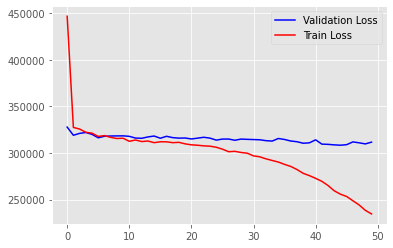

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Fill this in.
plt.plot(average_val_mae_history_pre_train,c="b")
plt.plot(average_train_mae_history_pre_train,c="r")
plt.legend(['Validation Loss','Train Loss'])
plt.show()